In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # ggplot2 drawing

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"

In [3]:
input_data_dir <- file.path("..","..","..","12.LOCO_BULK_MLP","results","Multi_Class","combined_channel_combinations",cell_type)
figure_dir <- file.path("..","figures",paste0("Multi_Class",model_name),cell_type)
# make figure dir if it does not exist
if (!dir.exists(figure_dir)){
    dir.create(figure_dir, recursive = TRUE)
}


In [4]:
# set file path for importing the data
training_metrics_file <- file.path(input_data_dir, "training_metrics.parquet")
confusion_matrix_file <- file.path(input_data_dir, "confusion_matrices.parquet")
pr_curves_path <- file.path(input_data_dir, "PR_curves.parquet")


# set output file path for graphs
f1_plot_path <- file.path(figure_dir,"f1_score.png")
confusion_matrix_plot_path <- file.path(figure_dir,"/confusion_matrix.png")

# read in the data
training_metrics <- arrow::read_parquet(training_metrics_file)
confusion_matrix <- arrow::read_parquet(confusion_matrix_file)
PR_curves <- arrow::read_parquet(pr_curves_path)


In [5]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [6]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Control", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("treatment_holdout", "Treatment Holdout", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffle <- gsub("TRUE", "Shuffled", f1_scores$shuffle)
f1_scores$shuffle <- gsub("FALSE", "Not Shuffled", f1_scores$shuffle)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)


In [7]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )


F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [8]:
head(f1_scores, 1)

,label,metric,value,group,shuffle,channel_combination,__index_level_0__,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<chr>,<int>,<dbl>
1,Apoptosis,f1-score,0,Training,Shuffled,CorrDNA_CorrGasdermin_CorrER,12,0


In [9]:
# remove the treatment holdout rows
f1_scores <- f1_scores[!grepl("Treatment Holdout", f1_scores$group),]

In [10]:
# replace keys with more readable names
# sort the unique keys by length
# get only select keys
f1_scores <- f1_scores %>% filter(
    channel_combination %in% c("All_channels", 
        "CorrDNA_CorrGasdermin_CorrMito_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrMito", 
        "CorrDNA_CorrPM_CorrMito_CorrER",
        "CorrPM_CorrGasdermin_CorrMito_CorrER"
    )
)

f1_scores$channel_combination <- gsub('All_channels', "All Channels", f1_scores$channel_combination)
f1_scores$channel_combination <- gsub('CorrDNA_CorrGasdermin_CorrMito_CorrER', "PM removed", f1_scores$channel_combination)
f1_scores$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrER' , "Mito removed", f1_scores$channel_combination)
f1_scores$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrMito' , "ER removed", f1_scores$channel_combination)
f1_scores$channel_combination <- gsub('CorrDNA_CorrPM_CorrMito_CorrER' , "GSDM removed", f1_scores$channel_combination)
f1_scores$channel_combination <- gsub('CorrPM_CorrGasdermin_CorrMito_CorrER' , "DNA removed", f1_scores$channel_combination)
# make the channel_combination a factor
f1_scores$channel_combination <- factor(f1_scores$channel_combination, levels = c(
    "All Channels", "GSDM removed", "DNA removed","ER removed", "Mito removed",  "PM removed"
)
)
    

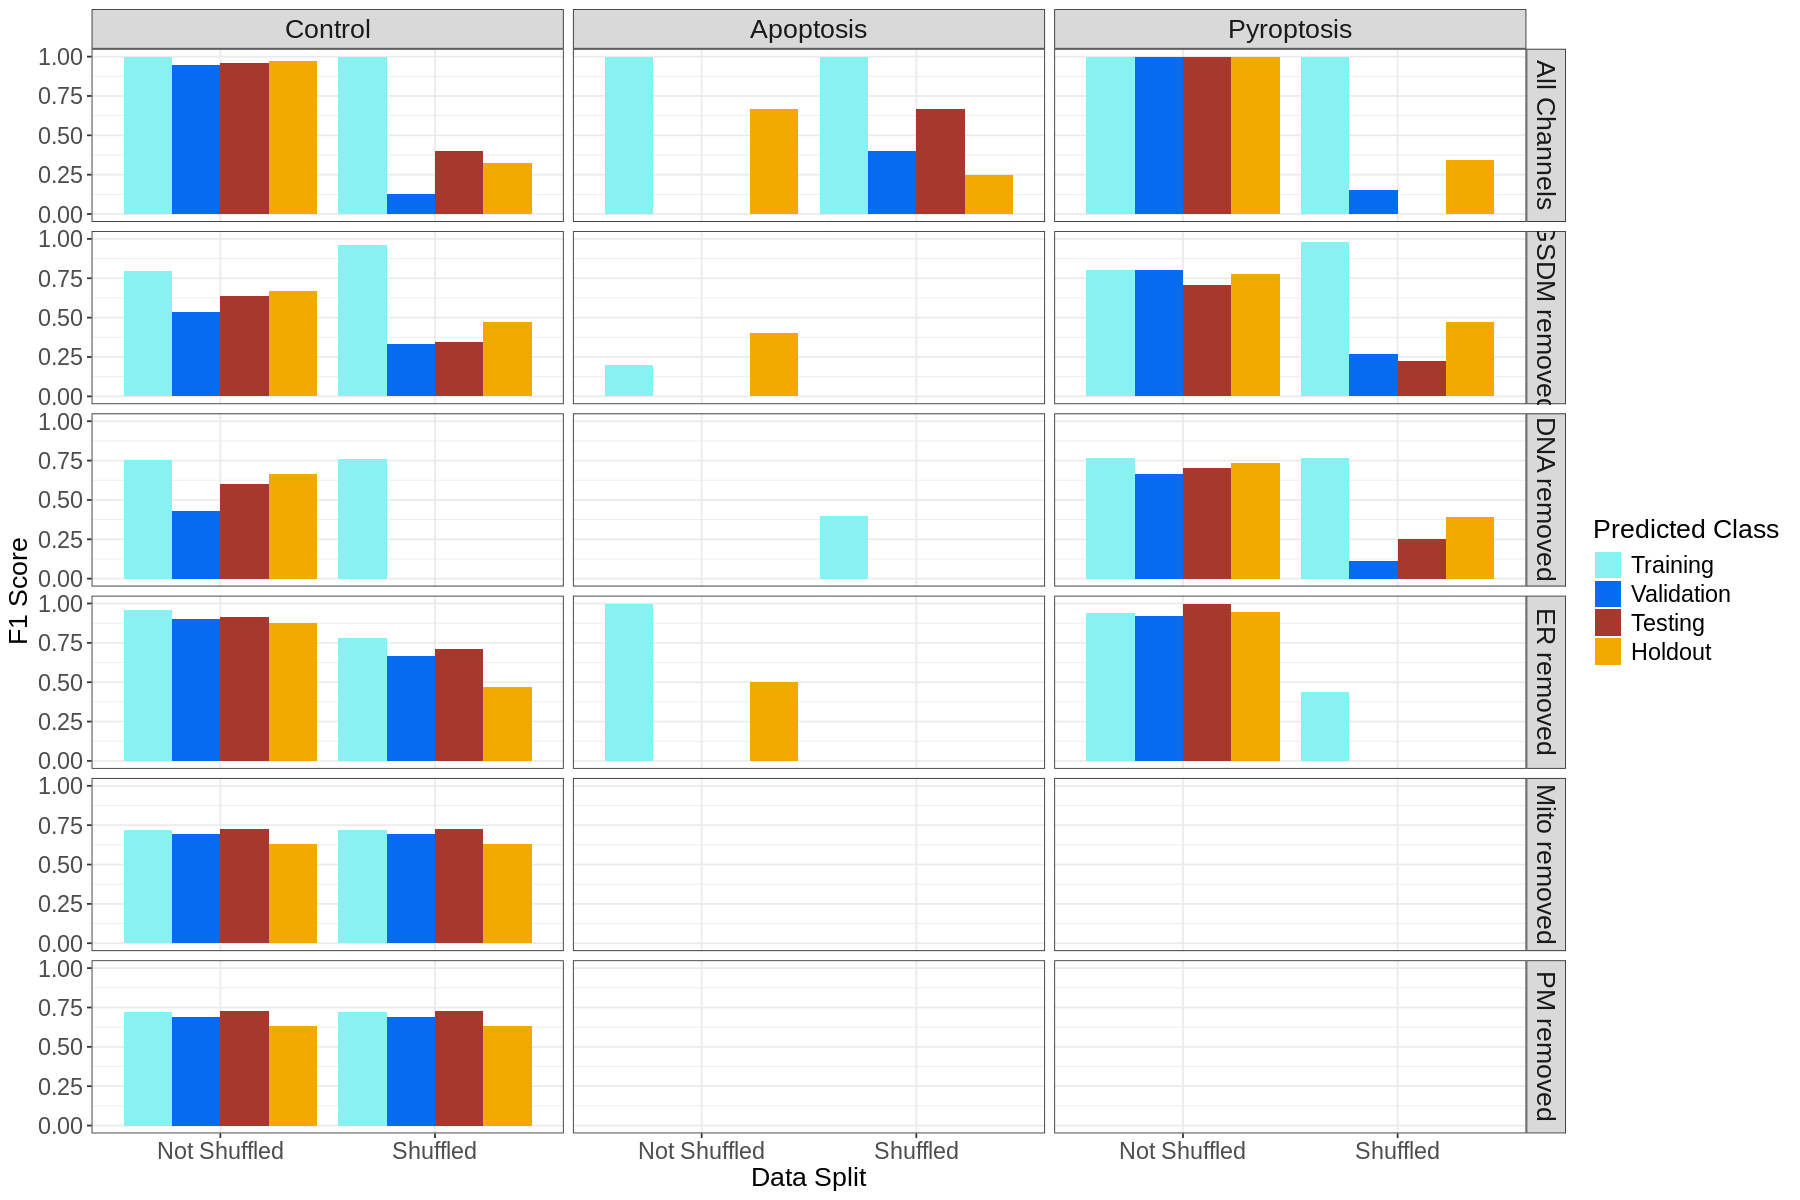

In [11]:
# set plot size
width <- 15
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffle, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    # + facet_wrap(~label)
    + facet_grid(channel_combination ~ label, scales = "free_y")
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Training" = "#88F2F2",
        "Validation" = "#056CF2",
        "Testing" = "#A6382E",
        "Holdout" = "#F2A900"
    ))
    + figure_theme_wide

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


## Confusion Matrix data plot

In [12]:
# round the Recall vlaues to 2 decimal places
confusion_matrix$Recall <- round(confusion_matrix$Recall, 2)
# mutate the label column for multiple cases
confusion_matrix$True_Label <- gsub("healthy", "Control", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$True_Label)
confusion_matrix$Predicted_Label <- gsub("healthy", "Control", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$Predicted_Label)

# make the True Label and Predicted Label columns factors
confusion_matrix$True_Label <- factor(
    confusion_matrix$True_Label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
confusion_matrix$Predicted_Label <- factor(
    confusion_matrix$Predicted_Label, levels = c(
       "Pyroptosis", "Apoptosis", "Control"
        )
    )
    
# mutate the data type column
confusion_matrix$data_split <- gsub("testing", "Testing", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("holdout", "Holdout wells", confusion_matrix$data_split)
# make the data split column a factor

unique(confusion_matrix$data_split)

[1] "Testing"       "Holdout wells"

In [13]:
# add the , to the count column
confusion_matrix$Count <- sapply(
    confusion_matrix$Count, function(x) format(x, big.mark = ",")
    )

head(confusion_matrix)

True_Label,Predicted_Label,Count,data_split,Recall,shuffle,channel_combination,__index_level_0__
<fct>,<fct>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<int>
Apoptosis,Control,0,Testing,0,TRUE,CorrDNA_CorrGasdermin_CorrER,0
Control,Control,12,Testing,1,TRUE,CorrDNA_CorrGasdermin_CorrER,1
Pyroptosis,Control,0,Testing,0,TRUE,CorrDNA_CorrGasdermin_CorrER,2
Apoptosis,Apoptosis,0,Testing,0,TRUE,CorrDNA_CorrGasdermin_CorrER,3
Control,Apoptosis,1,Testing,1,TRUE,CorrDNA_CorrGasdermin_CorrER,4
Pyroptosis,Apoptosis,0,Testing,0,TRUE,CorrDNA_CorrGasdermin_CorrER,5


In [14]:
# replace keys with more readable names
# sort the unique keys by length
# get only select keys
confusion_matrix <- confusion_matrix %>% filter(
    channel_combination %in% c("All_channels", 
        "CorrDNA_CorrGasdermin_CorrMito_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrMito", 
        "CorrDNA_CorrPM_CorrMito_CorrER",
        "CorrPM_CorrGasdermin_CorrMito_CorrER"
    )
)

confusion_matrix$channel_combination <- gsub('All_channels', "All Channels", confusion_matrix$channel_combination)
confusion_matrix$channel_combination <- gsub('CorrDNA_CorrGasdermin_CorrMito_CorrER', "PM removed", confusion_matrix$channel_combination)
confusion_matrix$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrER' , "Mito removed", confusion_matrix$channel_combination)
confusion_matrix$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrMito' , "ER removed", confusion_matrix$channel_combination)
confusion_matrix$channel_combination <- gsub('CorrDNA_CorrPM_CorrMito_CorrER' , "GSDM removed", confusion_matrix$channel_combination)
confusion_matrix$channel_combination <- gsub('CorrPM_CorrGasdermin_CorrMito_CorrER' , "DNA removed", confusion_matrix$channel_combination)
# make the channel_combination a factor
confusion_matrix$channel_combination <- factor(confusion_matrix$channel_combination, levels = c(
    "All Channels", "GSDM removed", "DNA removed","ER removed", "Mito removed",  "PM removed"
)
)


confusion_matrix$shuffle_plus_data_split <- paste0(confusion_matrix$shuffle, "_", confusion_matrix$data_split)
confusion_matrix$shuffle_plus_data_split <- gsub("TRUE_Testing", "Shuffled \n(Test)", confusion_matrix$shuffle_plus_data_split)
confusion_matrix$shuffle_plus_data_split <- gsub("TRUE_Holdout wells", "Shuffled \n(Holdout wells)", confusion_matrix$shuffle_plus_data_split)
confusion_matrix$shuffle_plus_data_split <- gsub("FALSE_Testing", "Final \n(Test)", confusion_matrix$shuffle_plus_data_split)
confusion_matrix$shuffle_plus_data_split <- gsub("FALSE_Holdout wells", "Final \n(Holdout wells)", confusion_matrix$shuffle_plus_data_split)
unique(confusion_matrix$shuffle_plus_data_split)
confusion_matrix$shuffle_plus_data_split <- factor(confusion_matrix$shuffle_plus_data_split, levels = c(
     "Final \n(Test)", "Final \n(Holdout wells)", "Shuffled \n(Test)","Shuffled \n(Holdout wells)"
)
)
unique(confusion_matrix$shuffle_plus_data_split)
head(confusion_matrix)

[1] "Shuffled \n(Test)"          "Shuffled \n(Holdout wells)"
[3] "Final \n(Test)"             "Final \n(Holdout wells)"

[1] Shuffled \n(Test)          Shuffled \n(Holdout wells)
[3] Final \n(Test)             Final \n(Holdout wells)   
4 Levels: Final \n(Test) Final \n(Holdout wells) ... Shuffled \n(Holdout wells)

True_Label,Predicted_Label,Count,data_split,Recall,shuffle,channel_combination,__index_level_0__,shuffle_plus_data_split
<fct>,<fct>,<chr>,<chr>,<dbl>,<lgl>,<fct>,<int>,<fct>
Apoptosis,Control,0,Testing,0,TRUE,DNA removed,0,Shuffled (Test)
Control,Control,0,Testing,0,TRUE,DNA removed,1,Shuffled (Test)
Pyroptosis,Control,12,Testing,1,TRUE,DNA removed,2,Shuffled (Test)
Apoptosis,Apoptosis,0,Testing,0,TRUE,DNA removed,3,Shuffled (Test)
Control,Apoptosis,0,Testing,0,TRUE,DNA removed,4,Shuffled (Test)
Pyroptosis,Apoptosis,1,Testing,1,TRUE,DNA removed,5,Shuffled (Test)


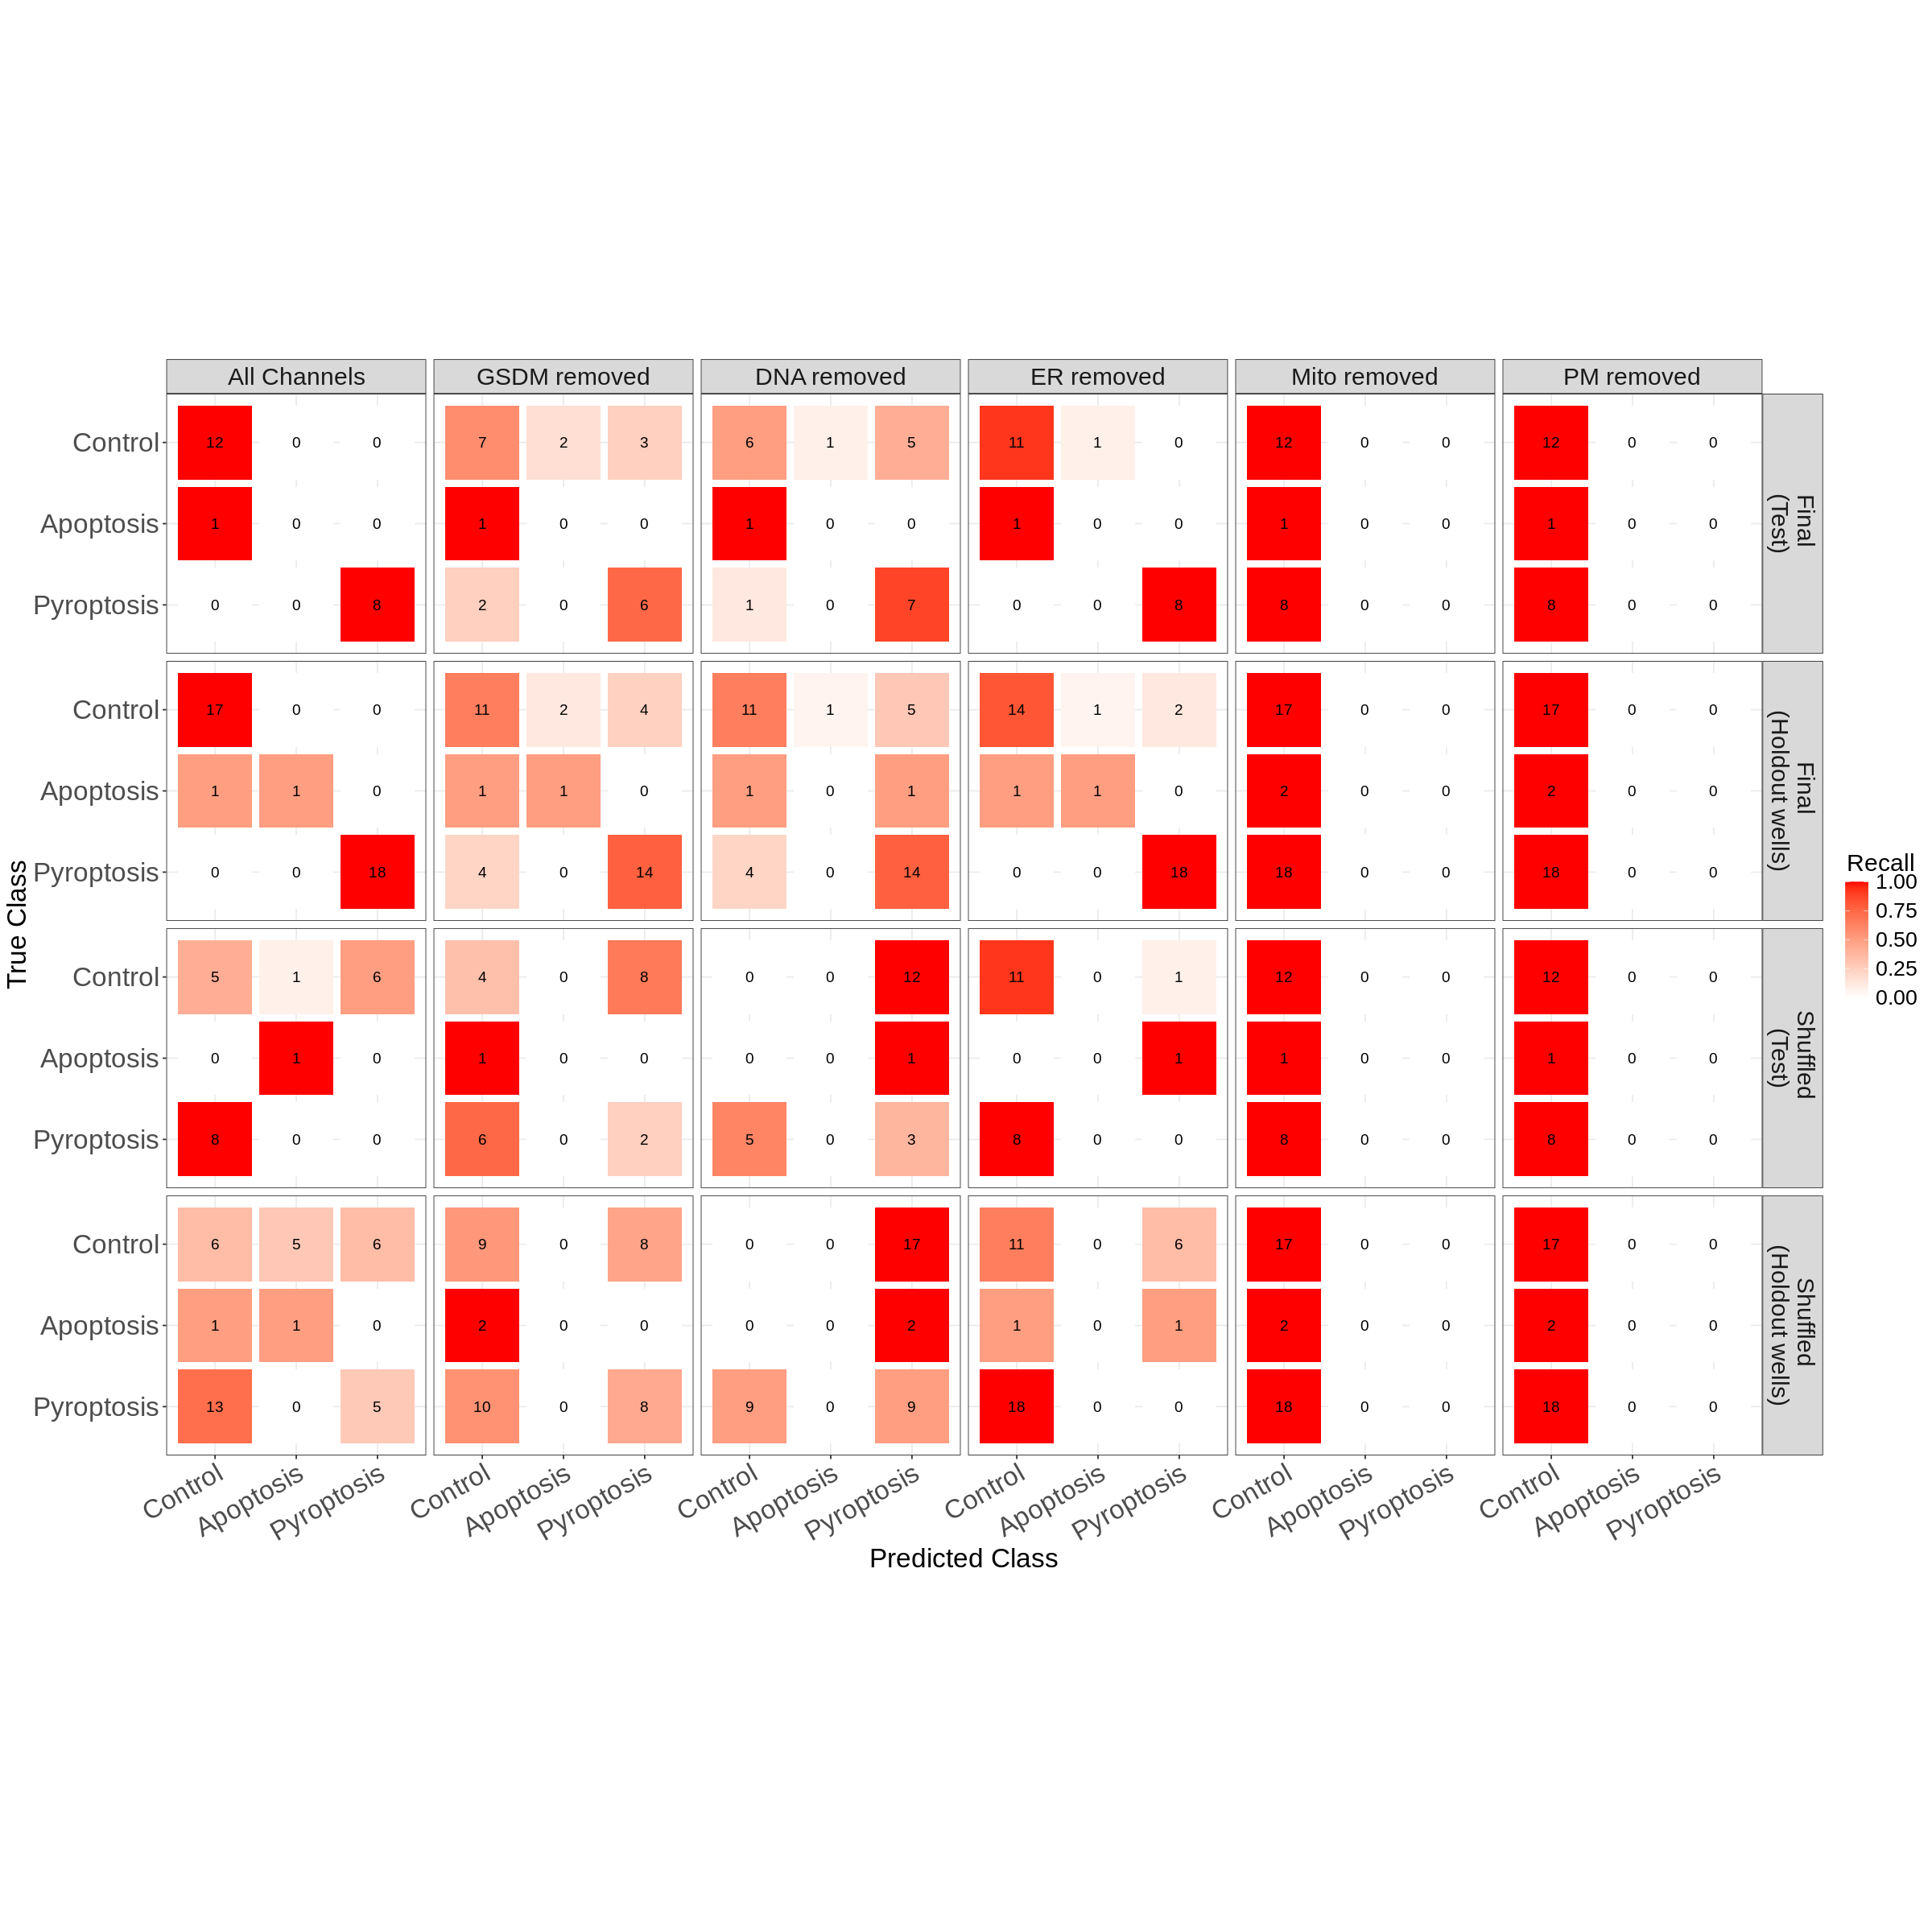

In [15]:
# plot dimensions
width <- 20
height <- 20
options(repr.plot.width = width, repr.plot.height = height)
# plot a confusion matrix
confusion_matrix_plot <- (
    ggplot(confusion_matrix, aes(x = True_Label, y = Predicted_Label))
    + facet_grid(shuffle_plus_data_split~channel_combination)
    + geom_point(aes(color = Recall), size = 25.5, shape = 15)
    + geom_text(aes(label = Count), size = 4)
    + scale_color_gradient("Recall", low = "white", high = "red",limits = c(0, 1))
    + theme_bw()
    + ylab("True Class")
    + xlab("Predicted Class")
    + figure_theme
    # change the legend title position
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 18),
            # make the scale text smaller
            label.theme = element_text(size = 16)
        )
    )
    # make the facet labels larger
    + theme(strip.text = element_text(size = 18))
    # x tick labels 45 degrees
    + theme(axis.text.x = element_text(angle = 30, hjust = 1))
    + ggplot2::coord_fixed()
    # make the right facet 


)
ggsave(confusion_matrix_plot_path, confusion_matrix_plot, width = width, height = height, dpi = 600)
confusion_matrix_plot


## PR Curves

In [16]:
# replace strings in pr_curves
PR_curves$label <- gsub("apoptosis", "Apoptosis", PR_curves$label)
PR_curves$label <- gsub("healthy", "Control", PR_curves$label)
PR_curves$label <- gsub("pyroptosis", "Pyroptosis", PR_curves$label)

PR_curves$data_split <- gsub("train", "Training", PR_curves$data_split)
PR_curves$data_split <- gsub("testing", "Testing", PR_curves$data_split)
PR_curves$data_split <- gsub("validation", "Validation", PR_curves$data_split)
PR_curves$data_split <- gsub("treatment_holdout", "Treatment Holdout", PR_curves$data_split)
PR_curves$data_split <- gsub("holdout", "Holdout wells", PR_curves$data_split)

# factorize the data_split column
PR_curves$data_split <- factor(PR_curves$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout wells"
))

unique(PR_curves$label)
unique(PR_curves$data_split)

# replace strings in pr_curves shuffle
PR_curves$shuffle <- gsub("TRUE", "Shuffled", PR_curves$shuffle)
PR_curves$shuffle <- gsub("FALSE", "Not Shuffled", PR_curves$shuffle)

# factorize the shuffled_data column
PR_curves$shuffle <- factor(PR_curves$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))
# class label factor
PR_curves$label <- factor(
    PR_curves$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
    
# remove the treatment holdout rows
PR_curves <- PR_curves[!grepl("Treatment Holdout", PR_curves$data_split),]


[1] "Apoptosis"  "Control"    "Pyroptosis"

[1] Training          Validation        Testing           Treatment Holdout
[5] Holdout wells    
Levels: Training Validation Testing Treatment Holdout Holdout wells

In [17]:
# replace keys with more readable names
# sort the unique keys by length
# get only select keys
PR_curves <- PR_curves %>% filter(
    channel_combination %in% c("All_channels", 
        "CorrDNA_CorrGasdermin_CorrMito_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrMito", 
        "CorrDNA_CorrPM_CorrMito_CorrER",
        "CorrPM_CorrGasdermin_CorrMito_CorrER"
    )
)
PR_curves$channel_combination <- gsub('All_channels', "All Channels", PR_curves$channel_combination)
PR_curves$channel_combination <- gsub('CorrDNA_CorrGasdermin_CorrMito_CorrER', "PM removed", PR_curves$channel_combination)
PR_curves$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrER' , "Mito removed", PR_curves$channel_combination)
PR_curves$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrMito' , "ER removed", PR_curves$channel_combination)
PR_curves$channel_combination <- gsub('CorrDNA_CorrPM_CorrMito_CorrER' , "GSDM removed", PR_curves$channel_combination)
PR_curves$channel_combination <- gsub('CorrPM_CorrGasdermin_CorrMito_CorrER' , "DNA removed", PR_curves$channel_combination)
# make the channel_combination a factor
PR_curves$channel_combination <- factor(PR_curves$channel_combination, levels = c(
    "All Channels", "GSDM removed", "DNA removed","ER removed", "Mito removed",  "PM removed"
)
)

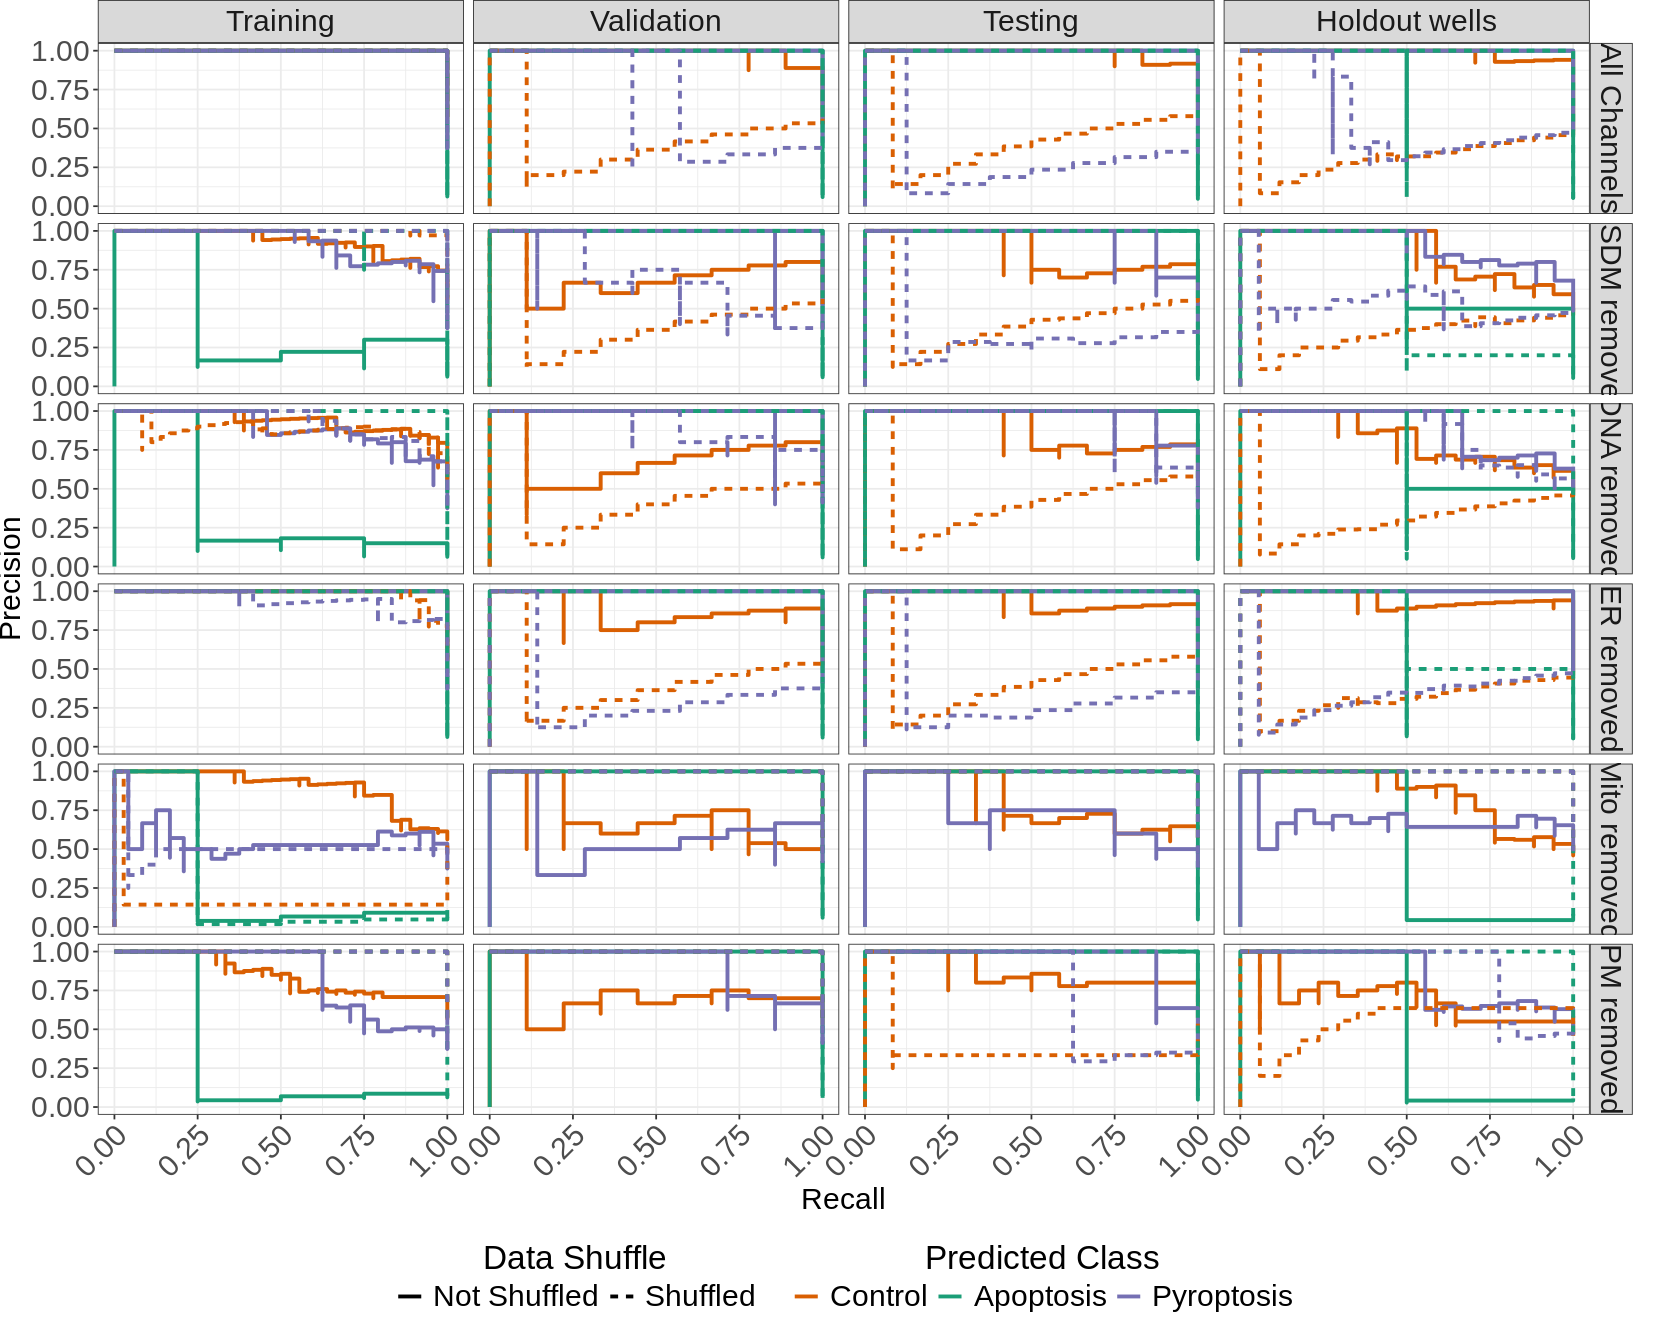

In [18]:
# make a line plot that has the shuffled and not shuffled lines
# with shuffled lines dashed and not shuffled lines solid
# color by label 
width <- 14
height <- 11
options(repr.plot.width = width, repr.plot.height = height)
pr_plot <- (
    ggplot(PR_curves, aes(x = recall, y = precision, color = label, linetype = label))
    + geom_step(aes(linetype = shuffle), linewidth = 1.1)
    # + geom_line(aes(linetype = shuffle), linewidth = 1.1)
    + facet_grid(channel_combination~data_split)
    + theme_bw()
    + labs(color = "Predicted Class", linetype = "Data Shuffle", x = "Recall", y = "Precision")
    # change the colours
    + scale_color_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    
    # change the facet text size
    + theme(
        strip.text = element_text(size = 18),
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # x and y axis title size
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
    )
    # change the legend position
    + theme(legend.position = "bottom")
    # make the legend horizontal
    + theme(legend.direction = "horizontal")
    + guides(
        linetype = guide_legend(
            order = 1, title.position = "top",
            title.theme = element_text(size = 20, hjust = 0.5)
            ),
        color = guide_legend(
            order = 2, title.position = "top",
            title.theme = element_text(size = 20, hjust = 0.5)
            )
            )
    # rotate the x axis tick labels
    + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    + theme(plot.margin = margin(0,1,0,0, "cm"))
)    
ggsave(file.path(figure_dir,"PR_curves.png"), pr_plot, width = width, height = height, dpi = 600)
pr_plot

## Probabilities

In [19]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(input_data_dir,"probabilities.parquet")
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_Well,labels,channel_combination,__index_level_0__
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0.1504245,0.5139767,0.3355989,2,1,train,TRUE,pyroptosis,148,O07,healthy,CorrDNA_CorrGasdermin_CorrER,0
0.1504245,0.5139767,0.3355989,2,1,train,TRUE,pyroptosis,94,J08,pyroptosis,CorrDNA_CorrGasdermin_CorrER,1


In [20]:
unique(probabilities$data_split)
unique(probabilities$shuffle)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

[1]  TRUE FALSE

In [21]:
# remove rows where shuffle is true
probabilities <- probabilities[!grepl("TRUE", probabilities$shuffle),]

In [22]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout
probabilities$data_split <- gsub("treatment_holdout", "Treatment Holdout", probabilities$data_split)
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout wells", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [23]:
head(probabilities, 2)
unique(probabilities$shuffle)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_Well,labels,channel_combination,__index_level_0__
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0.1908780,0.4355425,0.3735795,Pyroptosis,Control,Training,Not Shuffled,pyroptosis,148,O07,healthy,CorrDNA_CorrGasdermin_CorrER,154
0.1910283,0.4362681,0.3727037,Control,Control,Training,Not Shuffled,healthy,94,J08,pyroptosis,CorrDNA_CorrGasdermin_CorrER,155


[1] "Not Shuffled"

In [24]:
# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Pyroptosis", "Apoptosis", "Control"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout wells"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

# remove treatment holdout rows
probabilities <- probabilities[!grepl("Treatment Holdout", probabilities$data_split),]

In [25]:
# replace keys with more readable names
# sort the unique keys by length
# get only select keys
probabilities <- probabilities %>% filter(
    channel_combination %in% c("All_channels", 
        "CorrDNA_CorrGasdermin_CorrMito_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrER", 
        "CorrDNA_CorrPM_CorrGasdermin_CorrMito", 
        "CorrDNA_CorrPM_CorrMito_CorrER",
        "CorrPM_CorrGasdermin_CorrMito_CorrER"
    )
)

probabilities$channel_combination <- gsub('All_channels', "All Channels", probabilities$channel_combination)
probabilities$channel_combination <- gsub('CorrDNA_CorrGasdermin_CorrMito_CorrER', "PM removed", probabilities$channel_combination)
probabilities$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrER' , "Mito removed", probabilities$channel_combination)
probabilities$channel_combination <- gsub('CorrDNA_CorrPM_CorrGasdermin_CorrMito' , "ER removed", probabilities$channel_combination)
probabilities$channel_combination <- gsub('CorrDNA_CorrPM_CorrMito_CorrER' , "GSDM removed", probabilities$channel_combination)
probabilities$channel_combination <- gsub('CorrPM_CorrGasdermin_CorrMito_CorrER' , "DNA removed", probabilities$channel_combination)
# make the channel_combination a factor
probabilities$channel_combination <- factor(probabilities$channel_combination, levels = c(
    "All Channels", "GSDM removed", "DNA removed","ER removed", "Mito removed",  "PM removed"
)
)
unique(probabilities$channel_combination)

[1] DNA removed  ER removed   GSDM removed PM removed   Mito removed
[6] All Channels
6 Levels: All Channels GSDM removed DNA removed ER removed ... PM removed

Picking joint bandwidth of 0.000907

Picking joint bandwidth of 0.00647

Picking joint bandwidth of 0.0159

Picking joint bandwidth of 0.00667

Picking joint bandwidth of 0.0516

Picking joint bandwidth of 0.0423

Picking joint bandwidth of 0.0611

Picking joint bandwidth of 0.0611

Picking joint bandwidth of 0.0406

Picking joint bandwidth of 0.0538

Picking joint bandwidth of 0.0584

Picking joint bandwidth of 0.0545

Picking joint bandwidth of 0.0186

Picking joint bandwidth of 0.0512

Picking joint bandwidth of 0.0519

Picking joint bandwidth of 0.0372

Picking joint bandwidth of 0.0166

Picking joint bandwidth of 0.00835

Picking joint bandwidth of 0.0166

Picking joint bandwidth of 0.0172

Picking joint bandwidth of 0.0158

Picking joint bandwidth of 0.0136

Picking joint bandwidth of 0.0179

Picking joint bandwidth of 0.0146

Picking joint bandwidth of 0.000501

Picking joint bandwidth of 0.0066

Picking joint bandwidth of 0.00352

Picking joint bandwidth of 0.0014

Picking join

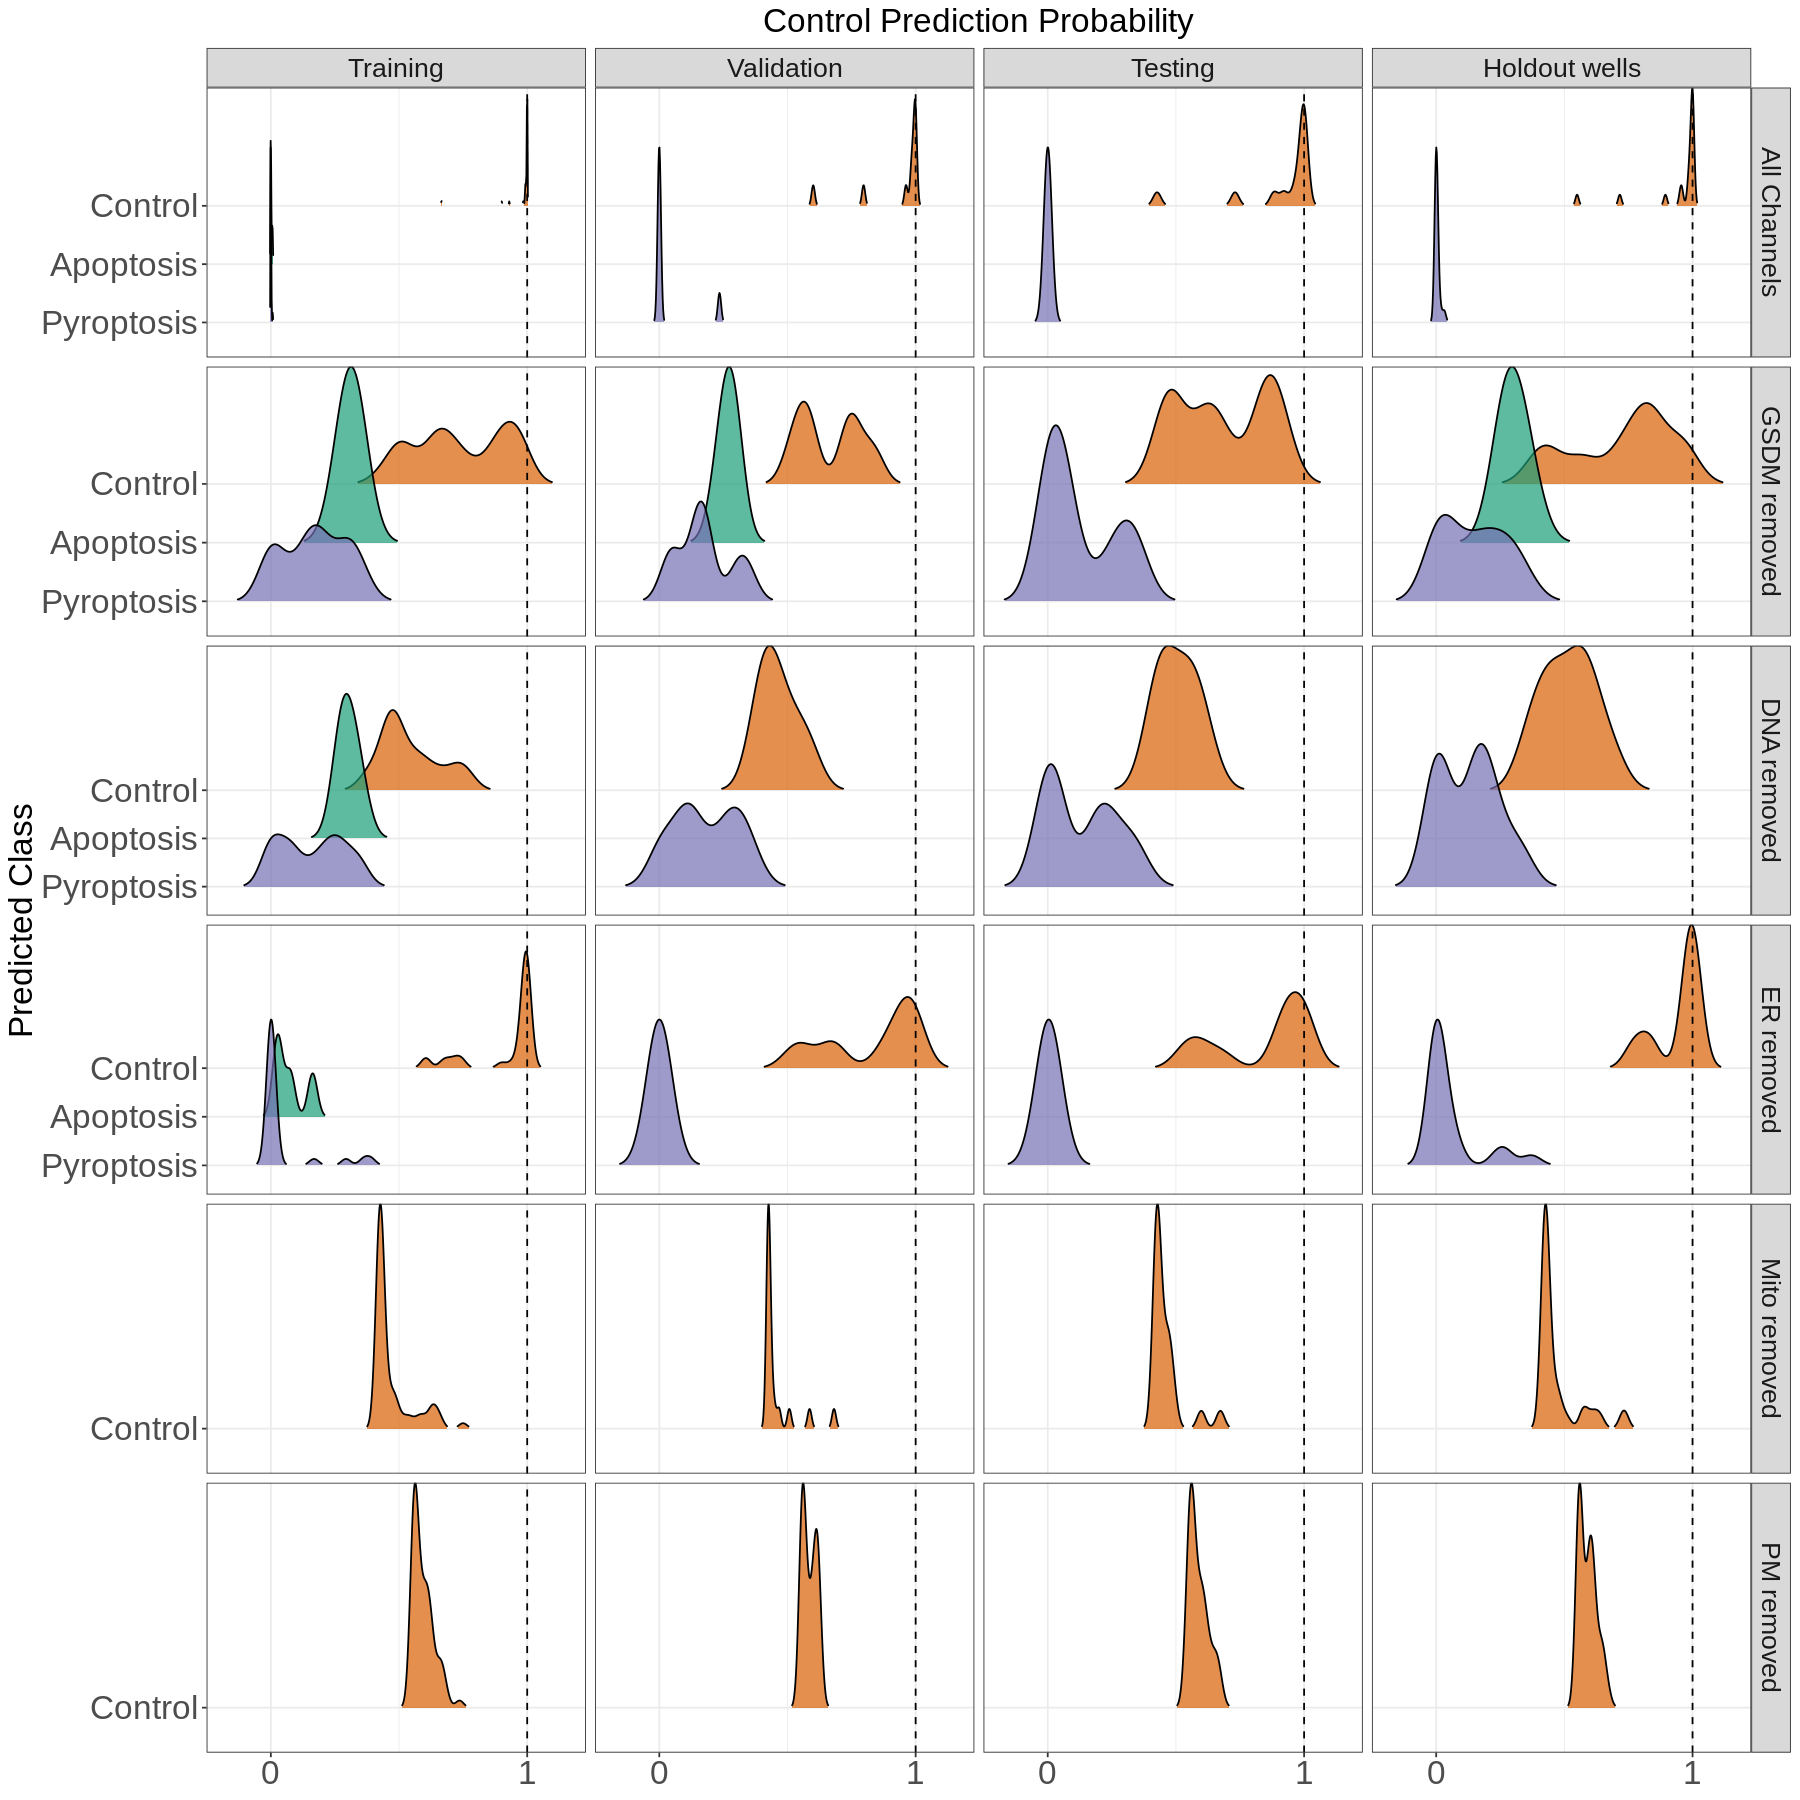

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.000179

Picking joint bandwidth of 0.00035

Picking joint bandwidth of 0.00741

Picking joint bandwidth of 0.00637

Picking joint bandwidth of 0.0531

Picking joint bandwidth of 0.0447

Picking joint bandwidth of 0.0761

Picking joint bandwidth of 0.0593

Picking joint bandwidth of 0.049

Picking joint bandwidth of 0.0667

Picking joint bandwidth of 0.0858

Picking joint bandwidth of 0.0736

Picking joint bandwidth of 0.00439

Picking joint bandwidth of 0.0324

Picking joint bandwidth of 0.0229

Picking joint bandwidth of 0.0385

Picking joint bandwidth of 0.00675

Picking joint bandwidth of 0.00388

Picking joint bandwidth of 0.00679

Picking joint bandwidth of 0.00702

Picking joint bandwidth of 0.00973

Picking joint bandwidth of 0.00873

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00908



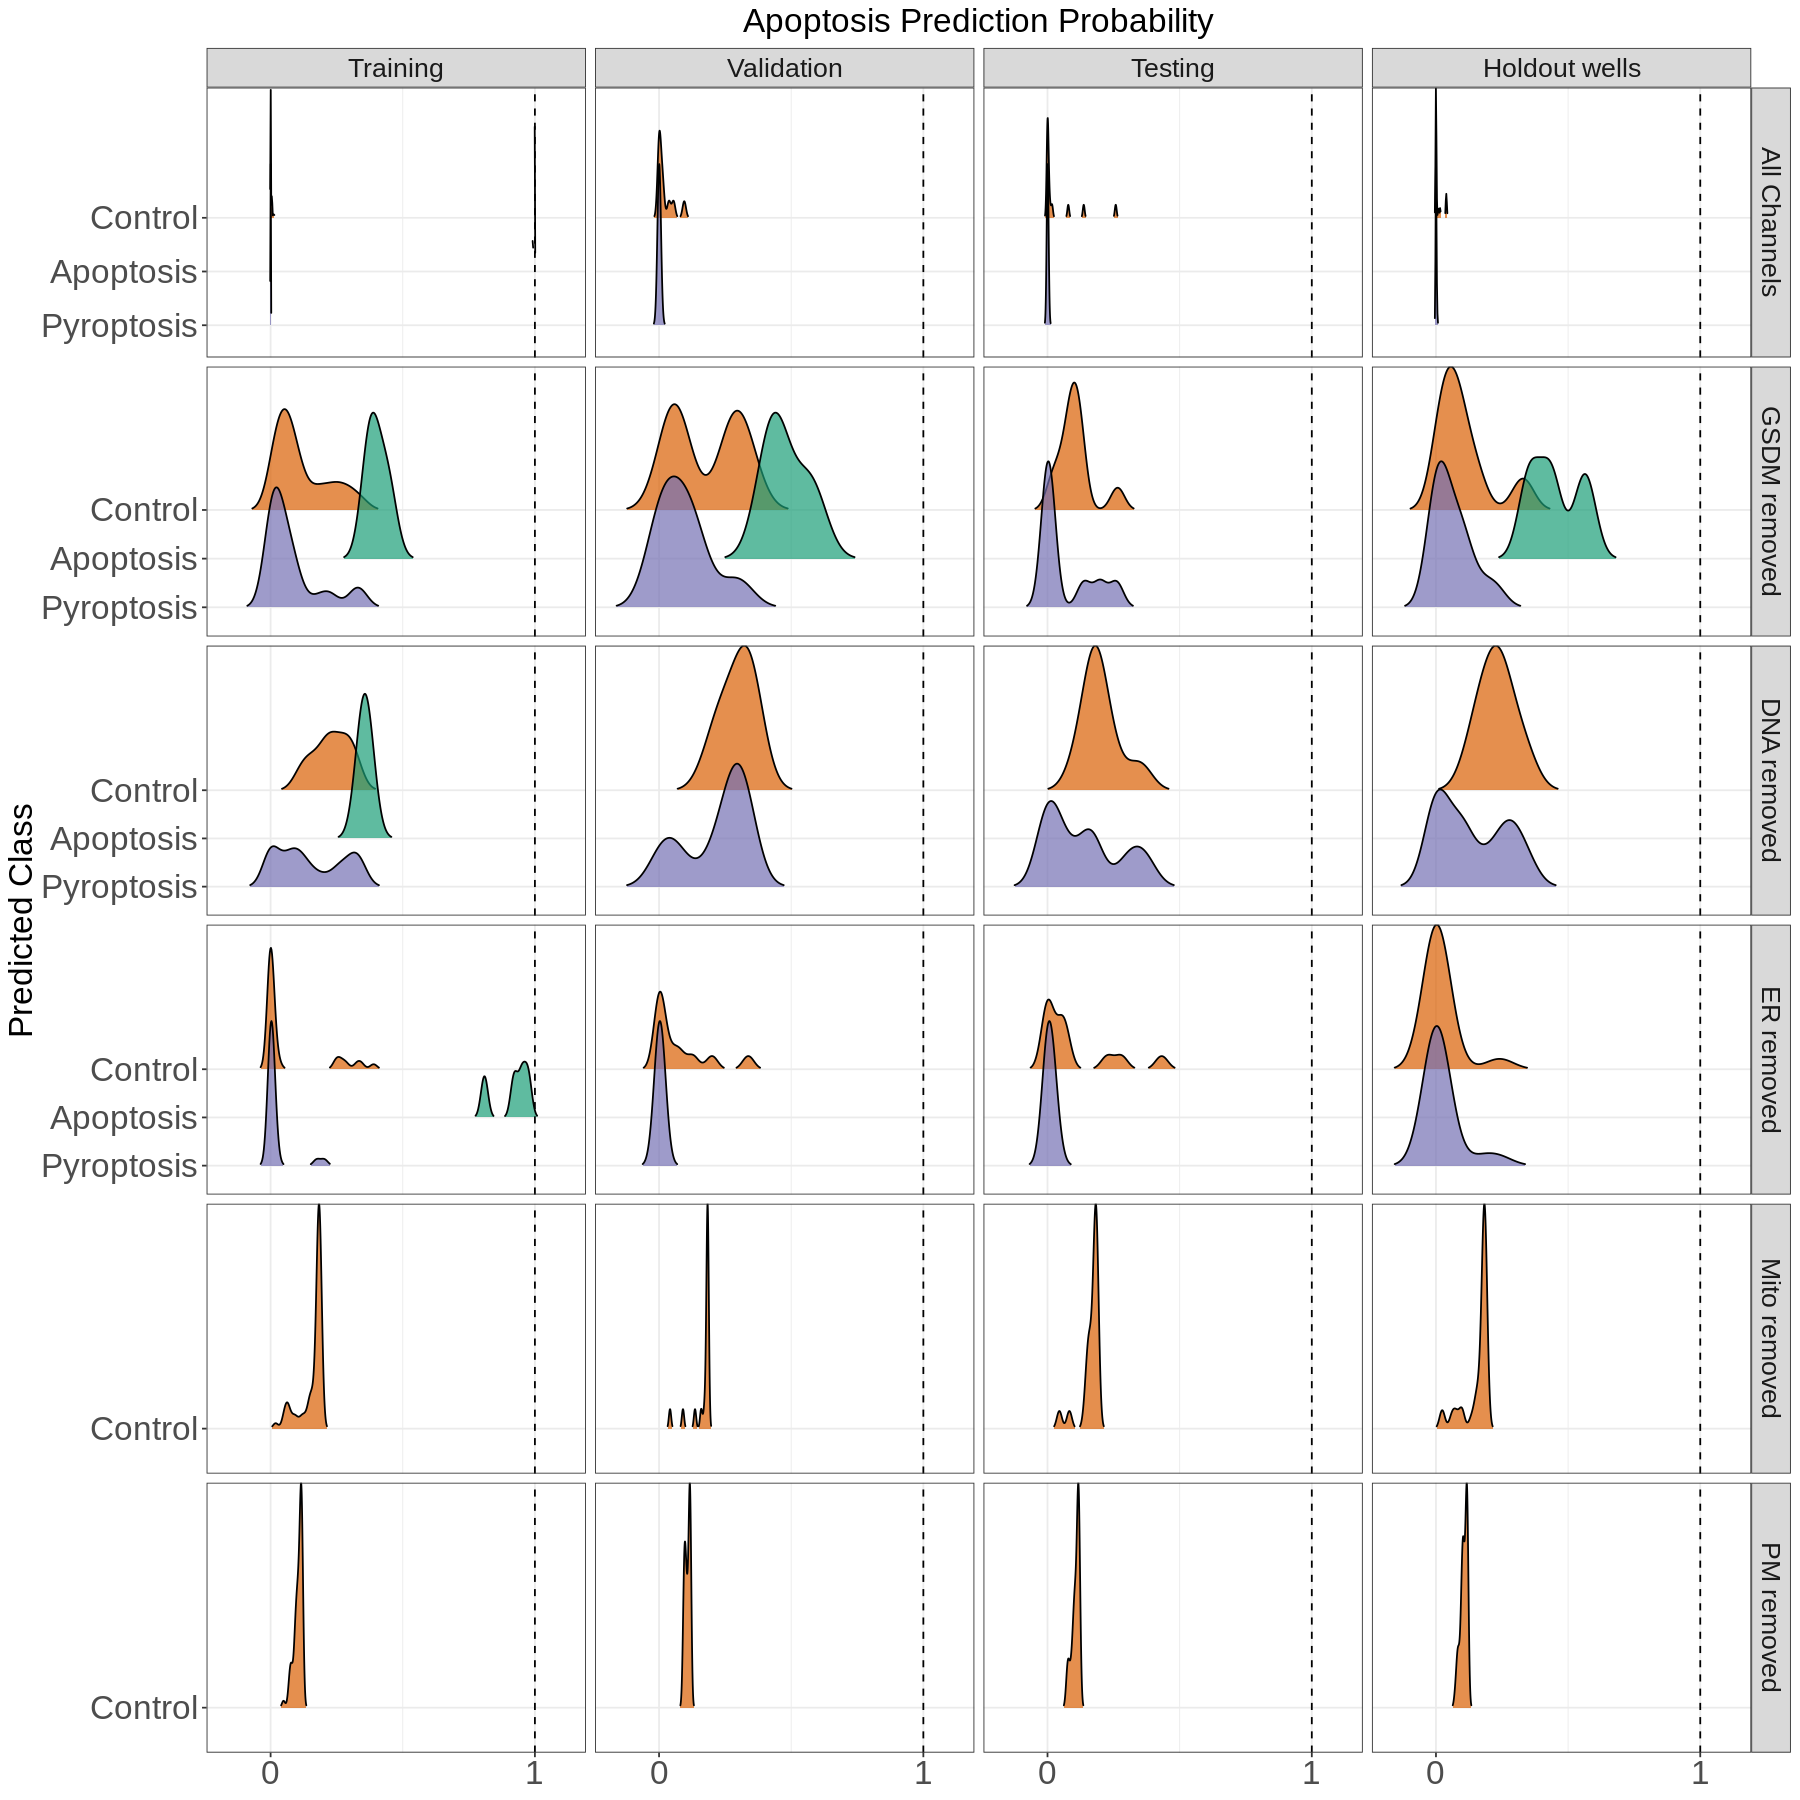

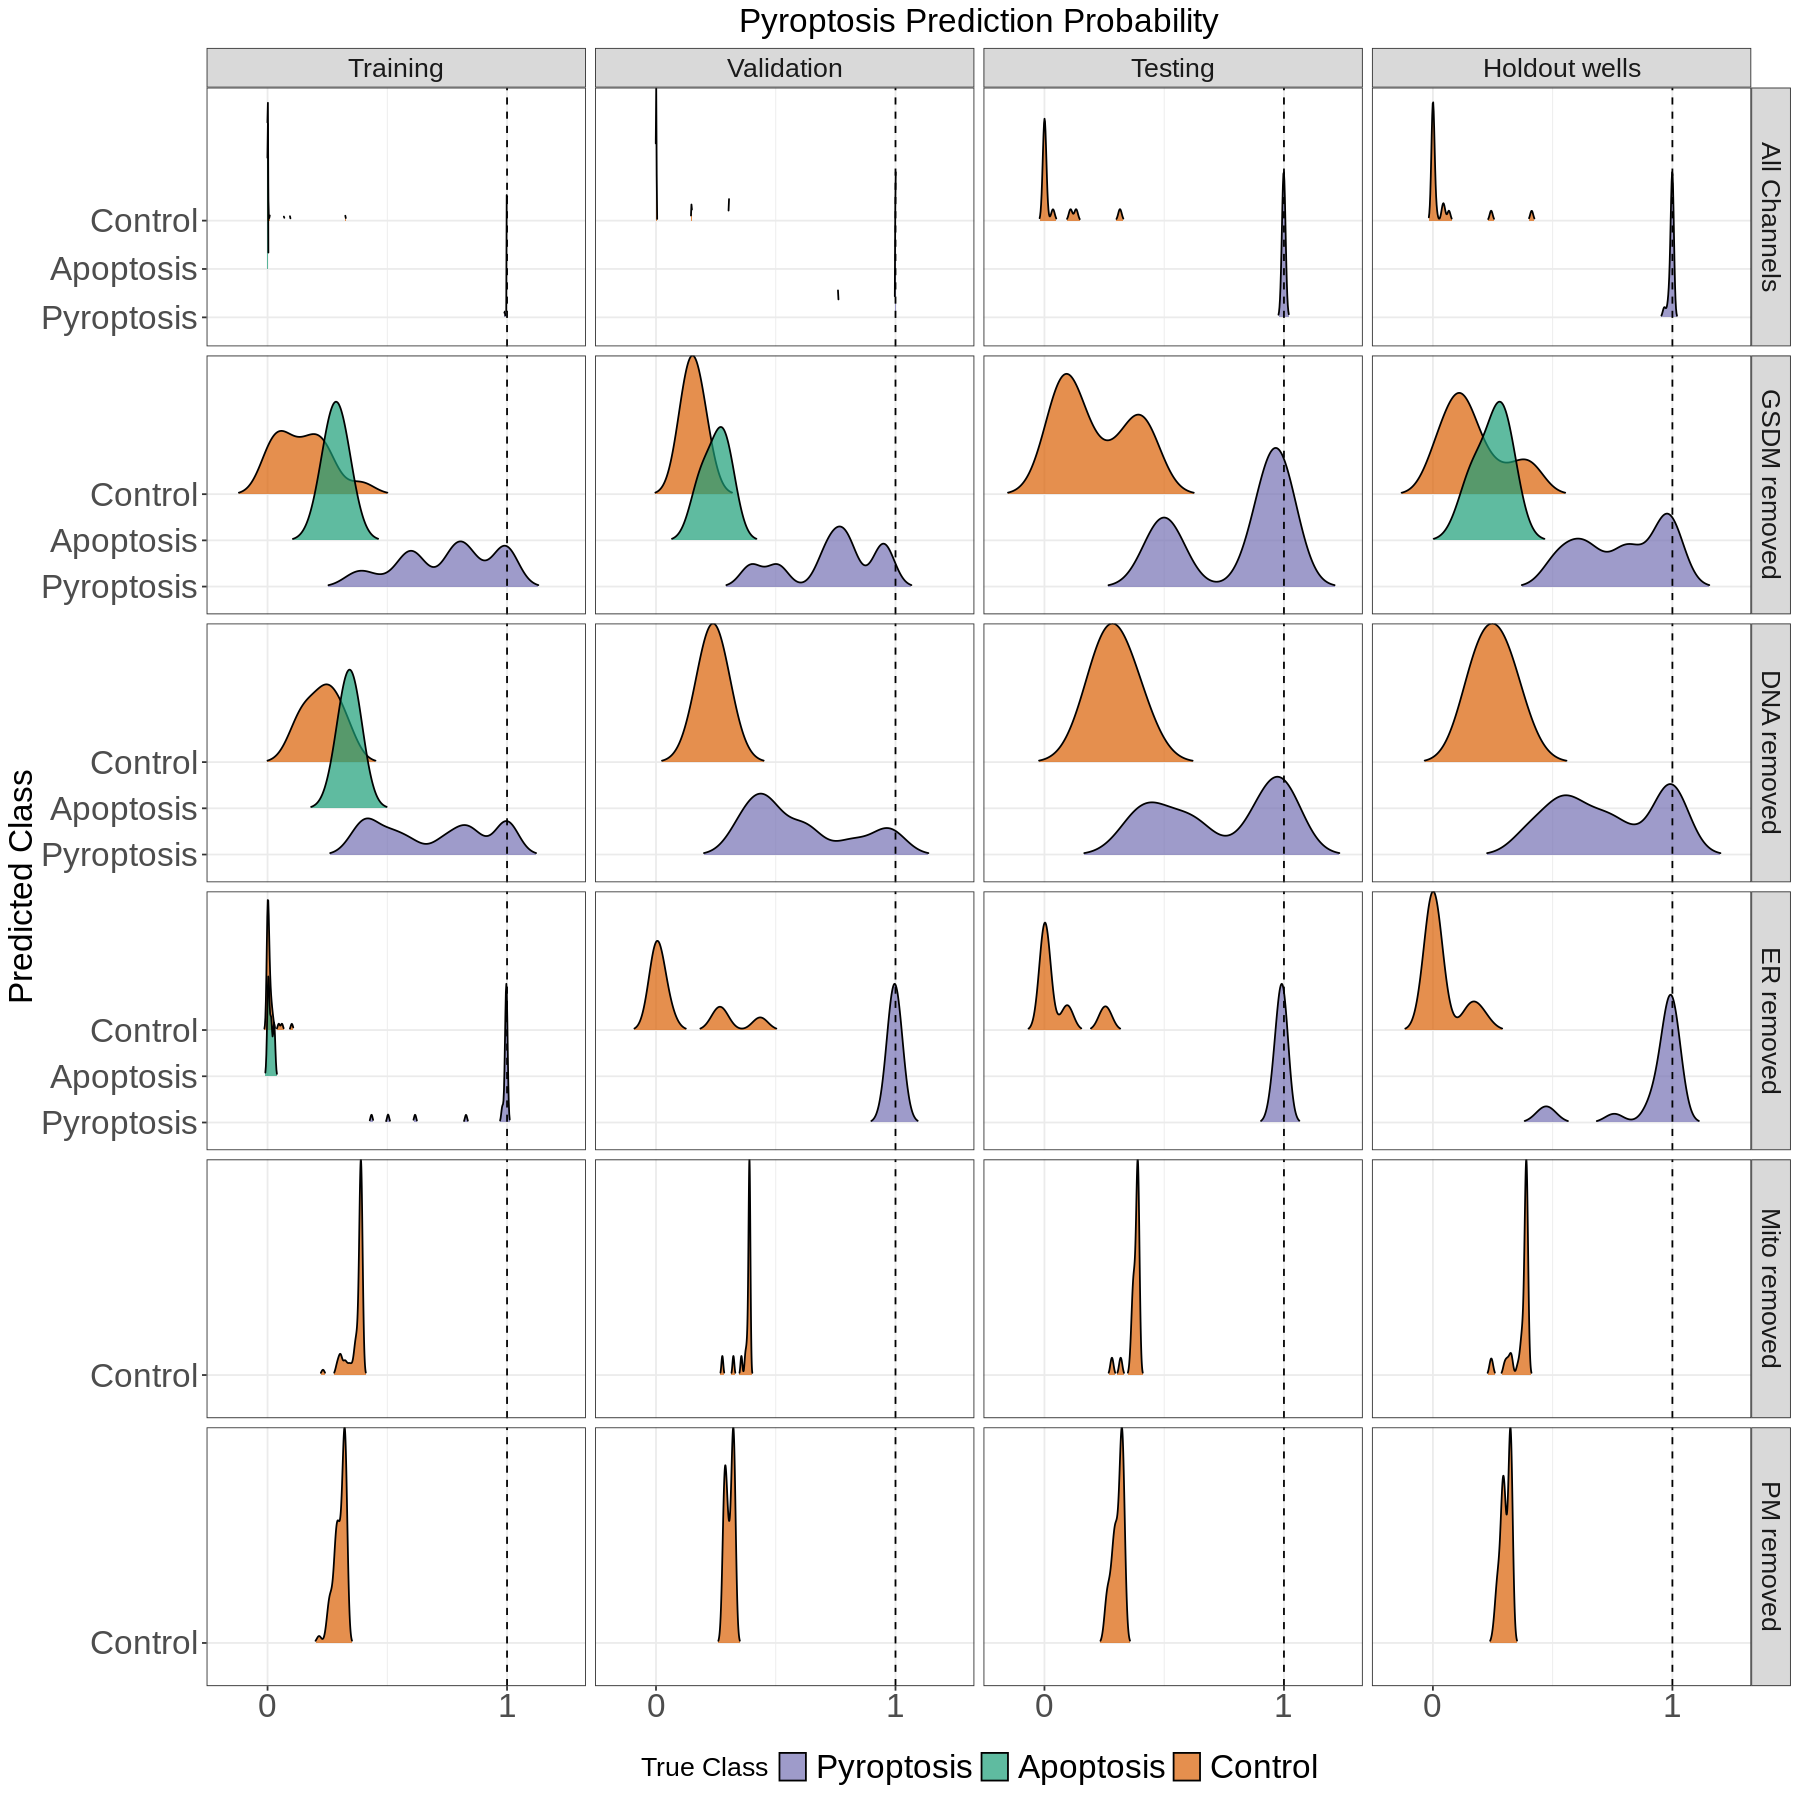

In [26]:
height <- 15
width <- 15
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_control <- (
    ggplot(probabilities, aes(x = control_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    # change color of the density ridges
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    

    + facet_grid(channel_combination~data_split, scales = "free_y")
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + scale_x_continuous(breaks = seq(0, ))
    + labs(title = "Control Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # no legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
)
ridge_plot_control


ridge_plot_apoptosis <- (
    ggplot(probabilities, aes(x = apoptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(channel_combination~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1))
    + labs(title = "Apoptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label   
    + theme(axis.title.x = element_blank())
)
ridge_plot_apoptosis

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(channel_combination~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + scale_x_continuous(breaks = seq(0, 1))
    + labs(title = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    # + theme(legend.position = "none")
    # make title larger
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
    # add vertical line at 1 
)
ridge_plot_pyroptosis


In [27]:
# get the legend
legend <- get_legend(ridge_plot_pyroptosis)
ridge_plot_pyroptosis <- (
    # remove the legend
    ridge_plot_pyroptosis + theme(legend.position = "none")
)

Picking joint bandwidth of 0.000179

Picking joint bandwidth of 0.00035

Picking joint bandwidth of 0.00741

Picking joint bandwidth of 0.00637

Picking joint bandwidth of 0.0531

Picking joint bandwidth of 0.0447

Picking joint bandwidth of 0.0761

Picking joint bandwidth of 0.0593

Picking joint bandwidth of 0.049

Picking joint bandwidth of 0.0667

Picking joint bandwidth of 0.0858

Picking joint bandwidth of 0.0736

Picking joint bandwidth of 0.00439

Picking joint bandwidth of 0.0324

Picking joint bandwidth of 0.0229

Picking joint bandwidth of 0.0385

Picking joint bandwidth of 0.00675

Picking joint bandwidth of 0.00388

Picking joint bandwidth of 0.00679

Picking joint bandwidth of 0.00702

Picking joint bandwidth of 0.00973

Picking joint bandwidth of 0.00873

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00908

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`

### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.000907

Picking joint bandwidth of 0.00647

Picking joint bandwidth of 0.0159

Picking joint bandwidth of 0.00667

Picking joint bandwidth of 0.0516

Picking joint bandwidth of 0.0423

Picking joint bandwidth of 0.0611

Picking joint bandwidth of 0.0611

Picking joint bandwidth of 0.0406

Picking joint bandwidth of 0.0538

Picking joint bandwidth of 0.0584

Picking joint bandwidth of 0.0545

Picking joint bandwidth of 0.0186

Picking joint bandwidth of 0.0512

Picking joint bandwidth of 0.0519

Picking joint bandwidth of 0.0372

Picking joint bandwidth of 0.0166

Picking joint bandwidth of 0.00835

Picking joint bandwidth of 0.0166

Picking joint bandwidth of 0.0172

Picking joint bandwidth of 0.0158

Picking joint bandwidth of 0.0136

Picking joint bandwidth of 0.0179

Picking joint bandwidth of 0.0146



Picking joint bandwidth of 0.000501

Picking joint bandwidth of 0.0066

Picking joint bandwidth of 0.00352

Picking joint bandwidth of 0.0014

Picking joint bandwidth of 0.0324

Picking joint bandwidth of 0.0592

Picking joint bandwidth of 0.0263

Picking joint bandwidth of 0.0406

Picking joint bandwidth of 0.0312

Picking joint bandwidth of 0.0535

Picking joint bandwidth of 0.0451

Picking joint bandwidth of 0.047

Picking joint bandwidth of 0.0133

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0238

Picking joint bandwidth of 0.0529

Picking joint bandwidth of 0.00983

Picking joint bandwidth of 0.00447

Picking joint bandwidth of 0.00982

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0061

Picking joint bandwidth of 0.00492

Picking joint bandwidth of 0.00613

Picking joint bandwidth of 0.00555

Picking joint bandwidth of 0.000179

Picking joint bandwidth of 0.00035

Picking joint bandwidth of 0.00741

Picking joint bandwidth of 0.00637

Picking

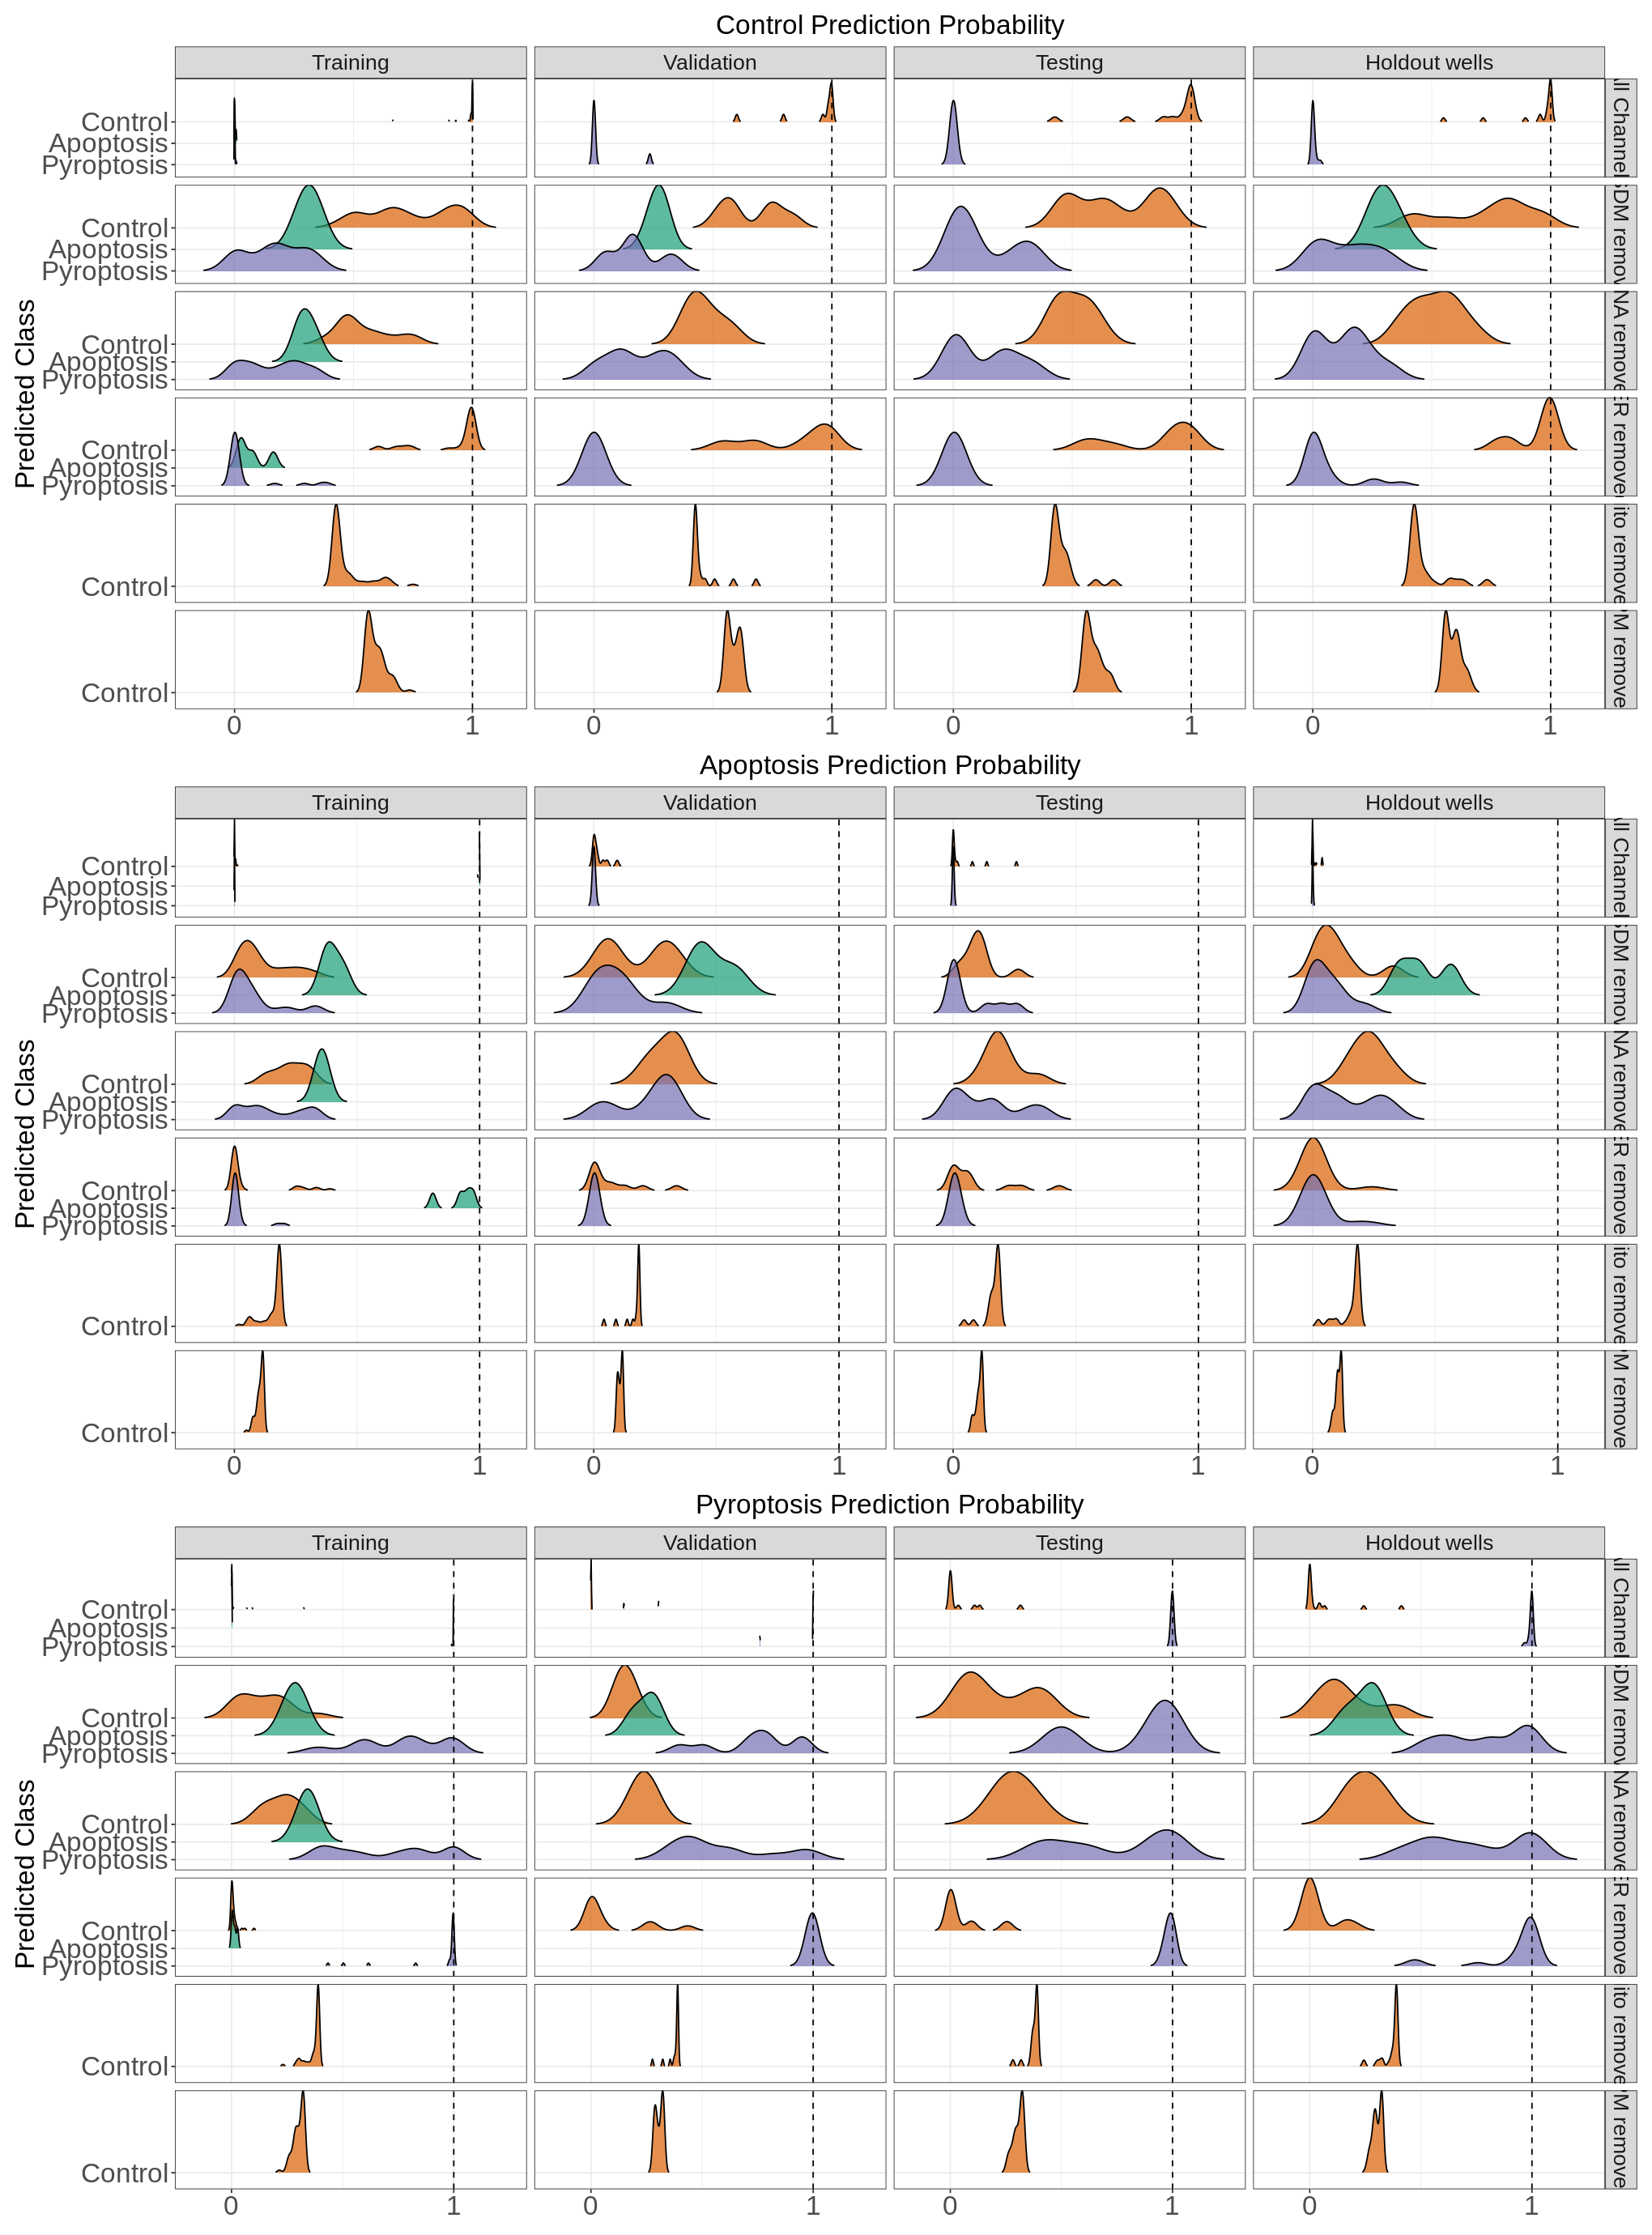

In [ ]:
# ridge_plot_apoptosis
# ridge_plot_control
# ridge_plot_pyroptosis
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 23
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
MLP_LOCO_probabilities <- (
    ridge_plot_control
    + ridge_plot_apoptosis
    + ridge_plot_pyroptosis
    + plot_layout(design = layout)
)
MLP_LOCO_probabilities